<a href="https://colab.research.google.com/github/DeeeTeeee/Store-Sales-Time-Series-Forecasting/blob/main/Store_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Project (Store Sales -- Time Series Forecasting)


In [ ]:
#!pip install category_encoders
#!pip install squarify
#!pip install pmdarima

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpathes
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import datetime as dt
import squarify

from scipy.stats import f_oneway
from datetime import datetime
from datetime import date

from  category_encoders import BinaryEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [ ]:
# For CSV, use pandas.read_csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
#Loading all datasets
holiday = pd.read_csv('/content/drive/MyDrive/lp2/holidays_events.csv',index_col=["date"],parse_dates=["date"])
oil = pd.read_csv('/content/drive/MyDrive/lp2/oil.csv', parse_dates=["date"])
stores = pd.read_csv('/content/drive/MyDrive/lp2/stores.csv')
test = pd.read_csv('/content/drive/MyDrive/lp2/test.csv',index_col=["date"],parse_dates=["date"])
train = pd.read_csv('/content/drive/MyDrive/lp2/train.csv',index_col=["date"],parse_dates=['date'])
transactions = pd.read_csv('/content/drive/MyDrive/lp2/transactions.csv',index_col=["date"],parse_dates=["date"])
sample_submission = pd.read_csv('/content/drive/MyDrive/lp2/sample_submission.csv')

## Exploratory Data Analysis: EDA

### Questions

#### 1. Is the train dataset complete (has all the required dates)?

#### 2. Which dates have the lowest and highest sales for each year?

#### 3. Did the earthquake impact sales?

#### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

#### 5. Are sales affected by promotions, oil prices and holidays?



### Hypothesis

##### Null Hypothesis:  Holidays do not affect the unit store sales
##### Alternate Hypothesis:  Holidays affect the sales in the store sales

### Data Overview
Here, the following were checked:<br>
* The shape of all the datasets
* The datatypes of the columns in the datasets
* Summary statistics
* Missing values

##### Data Shape

In [ ]:
# Print out the shapes of the datasets
print(f"The shape of the holiday dataset is: {holiday.shape}")
print(f"The shape of the oil dataset is: {oil.shape}")
print(f"The shape of the stores dataset is: {stores.shape}")
print(f"The shape of the test dataset is: {test.shape}")
print(f"The shape of the train dataset is: {train.shape}")
print(f"The shape of the transactions dataset is: {transactions.shape}")
print(f"The shape of the sample_submission dataset is: {sample_submission.shape}")

The shape of the holiday dataset is: (350, 5)
The shape of the oil dataset is: (1218, 2)
The shape of the stores dataset is: (54, 5)
The shape of the test dataset is: (28512, 4)
The shape of the train dataset is: (3000888, 5)
The shape of the transactions dataset is: (83488, 2)
The shape of the sample_submission dataset is: (28512, 2)


##### Datatypes

In [ ]:
# Print the data types of each dataset
def show_data_type(dataset_name, dataset):
    print(f"Data types for {dataset_name}:")
    print(dataset.dtypes)
    print('_' * 50)
        
show_data_type('Stores', stores)
show_data_type('Train', train)
show_data_type('Test', test)
show_data_type('Transactions', transactions)
show_data_type('Oil', oil)
show_data_type('Holiday', holiday)
show_data_type('Sample_Submission', sample_submission)



Data types for Stores:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
__________________________________________________
Data types for Train:
id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
__________________________________________________
Data types for Test:
id              int64
store_nbr       int64
family         object
onpromotion     int64
dtype: object
__________________________________________________
Data types for Transactions:
store_nbr       int64
transactions    int64
dtype: object
__________________________________________________
Data types for Oil:
date          datetime64[ns]
dcoilwtico           float64
dtype: object
__________________________________________________
Data types for Holiday:
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
_______

##### Summary Statistics

In [ ]:
#checking for the summary of the datasets:
datasets = {'holiday': holiday, 'oil': oil, 'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'sample_submission' : sample_submission}

for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset summary statistics:\n")
    print(data.describe())
    print('_' * 50)


Holiday dataset summary statistics:

           type    locale locale_name description transferred
count       350       350         350         350         350
unique        6         3          24         103           2
top     Holiday  National     Ecuador    Carnaval       False
freq        221       174         174          10         338
__________________________________________________

Oil dataset summary statistics:

        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
__________________________________________________

Stores dataset summary statistics:

       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
__________________________________________________

Trai

##### Missing Values

In [ ]:
# showing missing values in all dataset using a function

datasets = {'stores': stores, 'train': train, 'test': test, 'transactions': transactions, 'oil': oil, 'holiday': holiday, 'sample_submission' : sample_submission}

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in {name} dataset:")
        print(data.isnull().sum())
        print('_' * 50)

show_missing_values(datasets)


Missing values in stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
__________________________________________________
Missing values in train dataset:
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
__________________________________________________
Missing values in test dataset:
id             0
store_nbr      0
family         0
onpromotion    0
dtype: int64
__________________________________________________
Missing values in transactions dataset:
store_nbr       0
transactions    0
dtype: int64
__________________________________________________
Missing values in oil dataset:
date           0
dcoilwtico    43
dtype: int64
__________________________________________________
Missing values in holiday dataset:
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
__________________________________________________
Missing values in sample_sub

#### Comment:
* Missing data was found in the oil datasets.

#### Approach:
* The missing data were to be replaced by the mean value per month.<br> The rationale was to represent the missing values properly by the values over the month period.




In [ ]:
#replacing the nan with the mean of each month of its year
for year in range(2013, 2023):
    for month in range(1, 13):
        mask = (oil['date'].dt.month == month) & (oil['date'].dt.year == year)
        mean = oil.loc[mask, 'dcoilwtico'].mean()
        oil.loc[mask, 'dcoilwtico'] = oil.loc[mask, 'dcoilwtico'].fillna(mean)



In [ ]:
# Print the missing values in the dataset again to confirm that there are no missing values left
print(oil.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


### Merging Data

In [ ]:
# combine the datasets on common columns one after the other
merged_data1 = pd.merge(train, transactions, how='outer', on=['date', 'store_nbr'])
merged_data2 = pd.merge(merged_data1, holiday, how='outer', on='date')
merged_data3 = pd.merge(merged_data2, oil, how='outer', on='date')
merged_data = pd.merge(merged_data3, stores, how='outer', on='store_nbr')

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054427 entries, 0 to 3054426
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   id            float64       
 2   store_nbr     float64       
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   transactions  float64       
 7   type_x        object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  dcoilwtico    float64       
 13  city          object        
 14  state         object        
 15  type_y        object        
 16  cluster       float64       
dtypes: datetime64[ns](1), float64(7), object(9)
memory usage: 419.5+ MB


##### Renaming Columns

* Two columns had to be renamed. 
* 'type_x' column was changed to holiday_type
* 'type_y' column was changed to store_type

In [ ]:
#Renaming Columns
merged_data = merged_data.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})
merged_data.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
1,2013-01-01,1.0,1.0,BABY CARE,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
2,2013-01-01,2.0,1.0,BEAUTY,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
3,2013-01-01,3.0,1.0,BEVERAGES,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0
4,2013-01-01,4.0,1.0,BOOKS,0.0,0.0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,94.756667,Quito,Pichincha,D,13.0


In [ ]:
merged_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3054348.0,1.504277e+06,866261.012008,0.00,754676.75,1507571.50,2255120.250,3000887.00
store_nbr,3054348.0,2.750000e+01,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,3.590209e+02,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480e+00,12.254939,0.00,0.00,0.00,0.000,741.00
transactions,2805231.0,1.697071e+03,966.831652,5.00,1046.00,1395.00,2081.000,8359.00
dcoilwtico,2175837.0,6.791923e+01,25.672600,26.19,46.53,53.38,95.610,110.62
cluster,3054348.0,8.481481e+00,4.649735,1.00,4.00,8.50,13.000,17.00


#### Missing Values after merge

In [ ]:
merged_data.isna().sum()/len(merged_data)*100

date             0.000000
id               0.002586
store_nbr        0.002586
family           0.002586
sales            0.002586
onpromotion      0.002586
transactions     8.158519
holiday_type    83.545457
locale          83.545457
locale_name     83.545457
description     83.545457
transferred     83.545457
dcoilwtico      28.764479
city             0.002586
state            0.002586
store_type       0.002586
cluster          0.002586
dtype: float64

#### Approach:
* Drop missing values in sales column
* Create new category for missing values in holidays

In [ ]:
#drop missing values in sales
merged_data.dropna(subset=['sales'],inplace=True)

In [ ]:
#All unique columns in the holiday column
merged_data['holiday_type'].unique()

#Replacing missing values with a new category
merged_data['holiday_type'].replace(np.nan,'Not Holiday', inplace=True)



In [ ]:
merged_data.isna().sum()

date                  0
id                    0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type          0
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       878526
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

### Analysis

### 1. Is the train dataset complete (has all the required dates)?

In [ ]:
# Create a date range from the first date to the last date in the series
date_range = pd.date_range(start=train.index.min(), end=train.index.max())

# Check if there are any dates in the range that are not in the index
missing_dates = date_range.difference(train.index)

if len(missing_dates) == 0:
    print("The time series is complete.")
else:
    print("The time series is not complete. The following dates are missing:")
    print(missing_dates)

The time series is not complete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


### 2.  Which dates have the lowest and highest sales for each year?

In [ ]:
merged_data['year'] = pd.to_datetime(merged_data['date']).dt.year



#Group merged_data by year and date
grouped_data = merged_data.groupby(['year', 'date'])

#Calculate total sales for each date
sales_by_date = grouped_data['sales'].sum()


# Putting everything in a dataframe
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
lowest_sales = pd.DataFrame(sales_by_date.groupby('year').nsmallest(1))
highest_sales = pd.DataFrame(sales_by_date.groupby('year').nlargest(1))



# # Print dates with lowest and highest sales for each year
# # for year in merged_data['year'].unique():
# #     print("Year:", year)
# # print("Lowest sales:", lowest_sales['sales'])
# # print("Highest sales:", highest_sales['sales'])
# # print("-" * 50)


In [ ]:
#Dates with highest sales
highest_sales

,,,sales
year,year,date,
2013,2013,2013-12-22,"1,392,590.294"
2014,2014,2014-12-22,"2,016,286.692"
2015,2015,2015-12-22,"2,283,723.819"
2016,2016,2016-06-25,"2,580,890.505"
2017,2017,2017-06-25,"3,277,832.576"


In [ ]:
#Dates with lowest sales
lowest_sales

,,,sales
year,year,date,
2013,2013,2013-01-01,"2,511.619"
2014,2014,2014-01-01,"8,602.065"
2015,2015,2015-01-01,"12,773.617"
2016,2016,2016-01-01,"16,433.394"
2017,2017,2017-01-01,"12,082.501"


In [ ]:
# Group the merged_data by year and date, and calculate the minimum and maximum sales for each date
sales_by_date = merged_data.groupby(['year', 'date'])['sales'].agg(['min', 'max'])

# Create a slide object
slide = widgets.Output()

# Loop through each year, and plot the minimum and maximum sales for each date as two lines
for year in sales_by_date.index.get_level_values('year').unique():
    data = sales_by_date.loc[year]
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(data.index.get_level_values('date'), data['min'], label=f'Min Sales {year}')
    ax.plot(data.index.get_level_values('date'), data['max'], label=f'Max Sales {year}')
    ax.set_title(f'Lowest and Highest Sales for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend()
    # Display the figure in the slide
    with slide:
        display(fig)
    plt.close(fig)

# Display the slide
display(slide)


Output()

#### Insights:
 * From 2013 to 2015, the highest sales have been recorded in December.
 * However, the trends changed in 2016 and 2017 where the highest sales were recorded in June.
 * Perhaps, more promotions were carried out in June as compared to December

### 3. Did the earthquake impact sales?

 A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [ ]:
# merged_data[merged_data['date'] == '2016-04-16']['sales'].sum()
date = '2016-04-16'
sales_sum = merged_data[merged_data['date'] == date]['sales'].sum()
print("The sales for the date {} is ${:,.2f}".format(date, sales_sum))


The sales for the date 2016-04-16 is $862,121.49


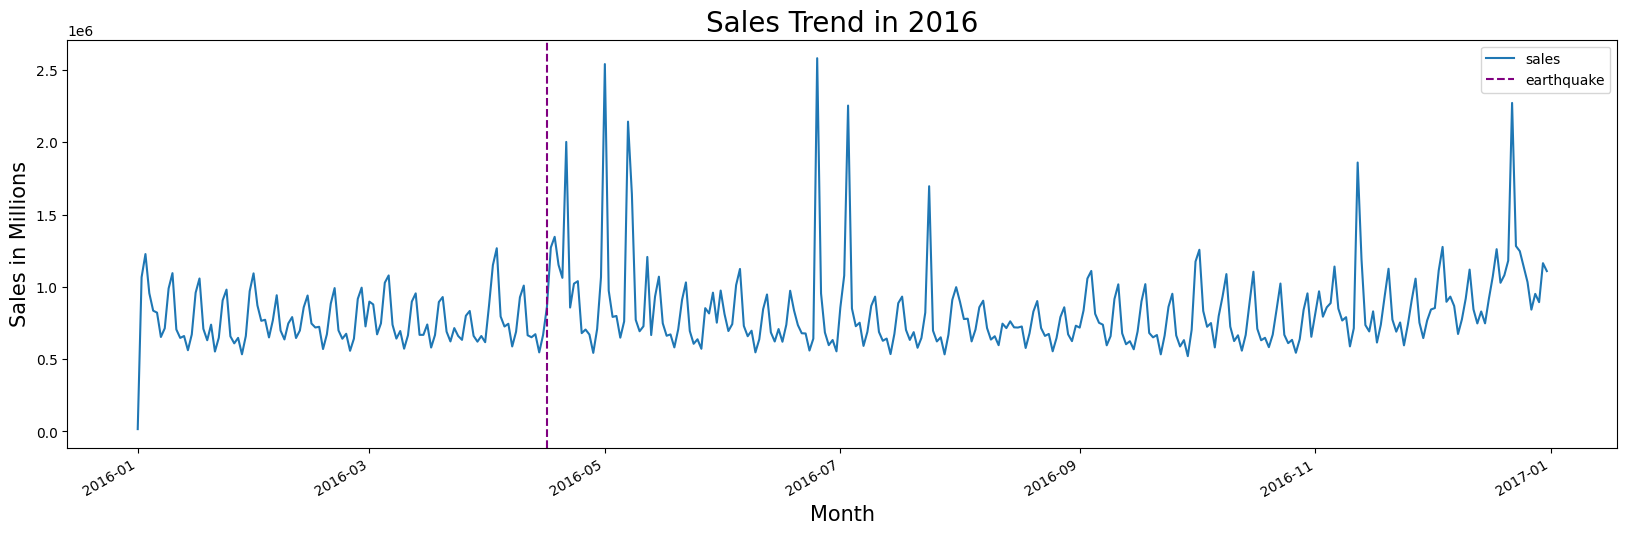

In [ ]:
#define earthquake date
earthquake = [pd.to_datetime('2016-04-16')]

#Obtain 2016 dataset
data16 = merged_data[merged_data['year'] ==2016]

#Plotting
ax = data16.groupby(['date'],as_index=False)['sales'].sum().plot(
    'date', 'sales', figsize=(20,6))
ax.axvline(earthquake, color='purple', linestyle='--')
ax.legend(['sales', 'earthquake'])
plt.title('Sales Trend in 2016',fontsize = 20)
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Sales in Millions', fontsize=15);

#### Insights
From the Graph:
* Sales were on a steady rise from previous weeks prior the earthquake.
* A few days after the earthquake, sales took a dip but rose steadily for about a week and suffered a major dip until May.
 

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

#### Collective grouping of cluster, city,state,type by transactions made

In [ ]:
# Here, the stores and transactions were merged to help analysis
merged = pd.merge(stores, transactions, on='store_nbr')

# group the merged dataset by cluster, city, state, and type and calculate the sum of transactions for each group
grouped = merged.groupby(['cluster', 'city', 'state', 'type'])['transactions'].sum()

# print the grouped data
print(grouped)


cluster  city           state                           type
1        Daule          Guayas                          D        2485687
         Guayaquil      Guayas                          D        3568206
         Salinas        Santa Elena                     D        1520362
2        Cuenca         Azuay                           D        3284365
3        El Carmen      Manabi                          C        1451290
         Guayaquil      Guayas                          C        2236356
         Machala        El Oro                          C        2181195
         Playas         Guayas                          C        1123889
         Quevedo        Los Rios                        C        1743003
         Santo Domingo  Santo Domingo de los Tsachilas  C        1464498
4        Loja           Loja                            D        2867052
         Machala        El Oro                          D        1764146
         Santo Domingo  Santo Domingo de los Tsachilas  D      

#### Group transactions made by city

In [ ]:
# Aggregate sales data by city
sales_by_city = merged.groupby('city')['transactions'].sum().reset_index().sort_values(by = 'transactions', ascending = False)
sales_by_city

,city,transactions
18,Quito,70999057
8,Guayaquil,16546295
0,Ambato,6172615
3,Cuenca,5673847
21,Santo Domingo,4655266
2,Cayambe,3972488
13,Machala,3945341
10,Latacunga,3531356
12,Loja,2867052
4,Daule,2485687


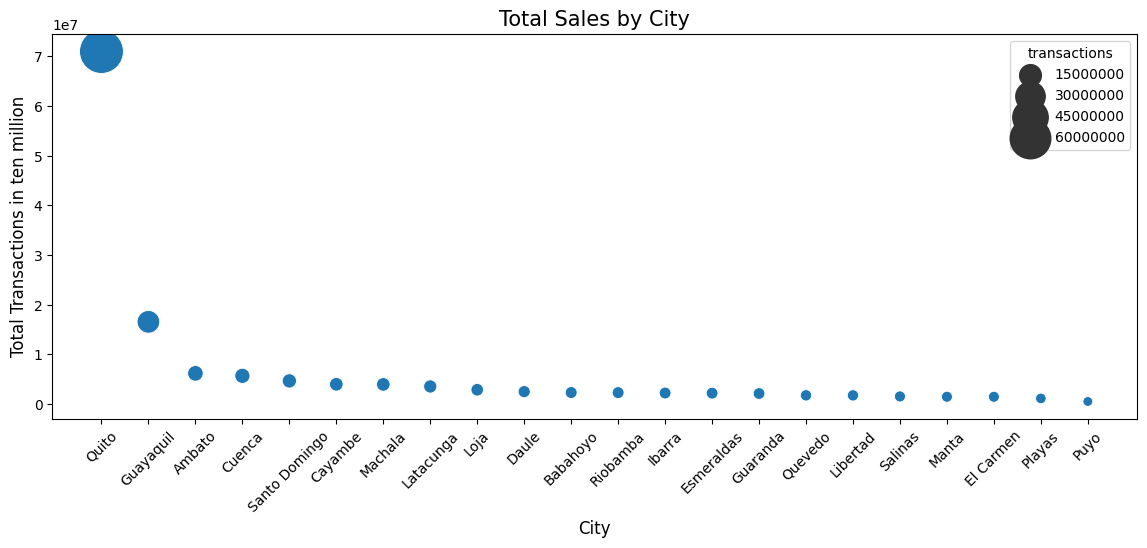

In [ ]:
# Create bubble plot
plt.figure(figsize=(14,5))
sns.scatterplot(x='city', y='transactions', size='transactions', sizes=(50, 1000), data=sales_by_city, palette='Set2')
plt.title('Total Sales by City', fontsize=15)
plt.xlabel('City',fontsize=12)
plt.ylabel('Total Transactions in ten million',fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Insights

* The City Quita recorded the highest sale transactions with Puyo recording the lowest

#### Group transactions by State

In [ ]:
# Group merged dataset by state and sum transactions
state_transactions = merged.groupby('state')['transactions'].sum().reset_index().sort_values(by = 'transactions', ascending = False)
state_transactions

,state,transactions
12,Pichincha,74971545
6,Guayas,21894000
15,Tungurahua,6172615
0,Azuay,5673847
14,Santo Domingo de los Tsachilas,4655266
9,Los Rios,4049047
4,El Oro,3945341
3,Cotopaxi,3531356
10,Manabi,2906765
8,Loja,2867052


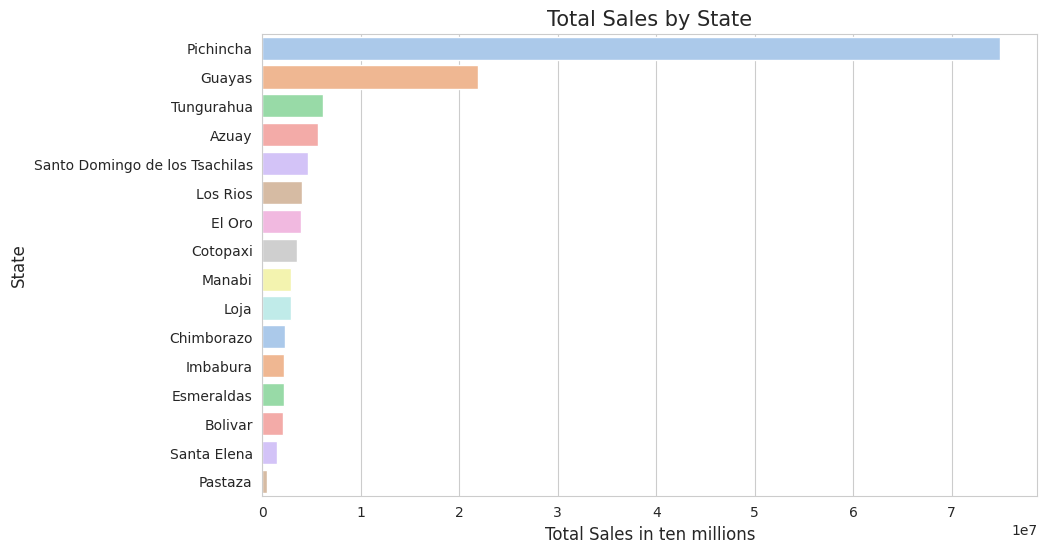

In [ ]:
#Create a horizontal bar chart with Seaborn
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(data=state_transactions,x ='transactions',y ='state', palette ='pastel')
plt.title('Total Sales by State',fontsize =15)
plt.xlabel('Total Sales in ten millions', fontsize =12)
plt.ylabel('State',fontsize =12)
plt.show()


#### Insights

The state with the highest sale transsactions is Pinchincha with Pastaza recording the lowest number of transactions

#### Group transactions by store

In [ ]:
trans_store = merged.groupby('type')['transactions'].sum().reset_index()

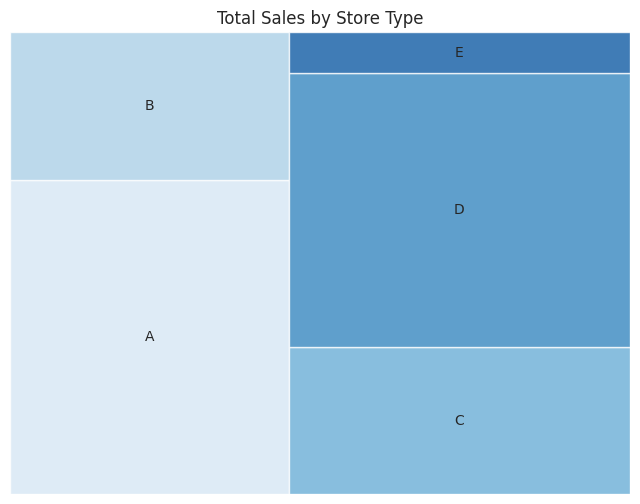

In [ ]:
# Set up the color gradient
colors = sns.color_palette('Blues', len(trans_store))
color_map = dict(zip(trans_store['type'], colors))

# Create the treemap
fig, ax = plt.subplots(figsize=(8, 6))
squarify.plot(sizes=trans_store['transactions'], label=trans_store['type'], alpha=0.8, color=[color_map[type] for type in trans_store['type']])
plt.axis('off')
plt.title('Total Sales by Store Type')
plt.show()


#### Insights

The store type D was found to record the highest number of transactions

### 5. Are sales affected by promotions, oil prices and holidays?

In [ ]:
# Calculate the correlation between sales and promotions
corr1 = merged_data['sales'].corr(merged_data['onpromotion'])
corr2 = merged_data['sales'].corr(merged_data['dcoilwtico'])

# Print the correlation coefficient
print('Correlation coefficient, Promotion:', corr1)
print('Correlation coefficient, Sales:', corr2)

Correlation coefficient, Promotion: 0.4282410665192464
Correlation coefficient, Sales: -0.0791611658452773


#### Insights

From the values obtained:
* Sales is positively correlated with promotion, thus an increase in promotion products may increase sales.
* However, the relationship is quite weak.
* Also, it can be deduced that the oil prices have a negative correlation with sales, thus, an increase in oil prices will may decrease sales at the stores due to increased prices which checks consumer spending.
* However, there relationship is very weak

#### Hypothesis for holiday column using ANOVA test

In [ ]:
holiday_list = merged_data.groupby('holiday_type')['sales'].apply(list)
Anova_results = f_oneway(*holiday_list)
print(Anova_results)

F_onewayResult(statistic=260.5458995720661, pvalue=0.0)


#### Insights
The p-value is less than the significant level 0.05 so we reject the null hypothesis. That is, holiday columns are correlated with the sales made. Thus, sales are affected by holidays

### Feature Processing

In [ ]:
#drop unnecessary columns
merged_data = merged_data.drop(columns=['id','locale', 'locale_name', 'description', 'transferred'])

In [ ]:
#drop columns for univariate analysis
merged_data1 = merged_data.drop(columns=['store_nbr','family','state','onpromotion','transactions','city','dcoilwtico','holiday_type','cluster','year','store_type'])

### Feature Engineering

In [ ]:
def getDateFeatures(df,date):
    df['month'] = df['date'].dt.month
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['day'] = df['date'].dt.day
    df['is_weekend'] = df['date'].dt.isocalendar().week
    df['day_of_the_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    return df

In [ ]:
merged_data = getDateFeatures(merged_data, 'date')

In [ ]:
merged_data

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,state,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,2013-01-01,1.000,AUTOMOTIVE,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
1,2013-01-01,1.000,BABY CARE,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
2,2013-01-01,1.000,BEAUTY,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
3,2013-01-01,1.000,BEVERAGES,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
4,2013-01-01,1.000,BOOKS,0.000,0.000,NaN,Holiday,94.757,Quito,Pichincha,...,2013,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9.000,POULTRY,438.133,0.000,"2,155.000",Holiday,47.570,Quito,Pichincha,...,2017,8,0,0,15,33,227,3,0,0
3054344,2017-08-15,9.000,PREPARED FOODS,154.553,1.000,"2,155.000",Holiday,47.570,Quito,Pichincha,...,2017,8,0,0,15,33,227,3,0,0
3054345,2017-08-15,9.000,PRODUCE,"2,419.729",148.000,"2,155.000",Holiday,47.570,Quito,Pichincha,...,2017,8,0,0,15,33,227,3,0,0
3054346,2017-08-15,9.000,SCHOOL AND OFFICE SUPPLIES,121.000,8.000,"2,155.000",Holiday,47.570,Quito,Pichincha,...,2017,8,0,0,15,33,227,3,0,0


### Binary Encoding

In [ ]:
# Import necessary libraries
from  category_encoders import BinaryEncoder

# Instantiate BinaryEncoder
ce = BinaryEncoder

encoder = ce(cols=['family','city','state','store_type','cluster','holiday_type'], drop_invariant=True)
merged_data = encoder.fit_transform(merged_data)

In [ ]:
merged_data.sample(8)

,date,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
35585,2015-12-03,1.000,0,0,1,1,0,0,240.561,0.000,...,2015,12,0,0,3,49,337,4,0,0
898959,2017-02-18,23.000,0,0,0,1,1,1,16.000,0.000,...,2017,2,0,0,18,7,49,1,0,0
1011578,2017-02-02,25.000,0,1,1,1,1,0,47.364,2.000,...,2017,2,0,0,2,5,33,1,0,0
102746,2016-10-10,10.000,0,1,0,0,1,0,0.000,0.000,...,2016,10,0,0,10,41,284,4,0,0
1275033,2015-07-07,3.000,0,0,1,1,0,1,"5,097.000",7.000,...,2015,7,0,0,7,28,188,3,0,0
731958,2017-05-09,20.000,0,1,0,0,1,1,325.000,11.000,...,2017,5,0,0,9,19,129,2,0,0
190861,2014-09-26,12.000,0,1,0,1,1,1,77.000,0.000,...,2014,9,0,0,26,39,269,3,0,0
874659,2015-02-25,23.000,0,1,1,1,0,0,0.000,0.000,...,2015,2,0,0,25,9,56,1,0,0


### Feature Drop

In [ ]:
# drop columns
merged_data = merged_data.drop(columns=['date'])

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['store_nbr','sales', 'transactions', 'dcoilwtico', 'year','month','is_month_start','is_month_end','day','is_weekend','day_of_the_year','quarter','is_quarter_start','is_quarter_end']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

In [ ]:
merged_data

,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,transactions,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,-1.700,0,0,0,0,0,1,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
1,-1.700,0,0,0,0,1,0,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
2,-1.700,0,0,0,0,1,1,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
3,-1.700,0,0,0,1,0,0,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
4,-1.700,0,0,0,1,0,1,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,-1.187,0,1,1,1,0,1,0.071,0.000,0.474,...,1.603,0.527,-0.185,-0.182,-0.075,0.521,0.515,0.535,-0.106,-0.103
3054344,-1.187,0,1,1,1,1,0,-0.185,1.000,0.474,...,1.603,0.527,-0.185,-0.182,-0.075,0.521,0.515,0.535,-0.106,-0.103
3054345,-1.187,0,1,1,1,1,1,1.861,148.000,0.474,...,1.603,0.527,-0.185,-0.182,-0.075,0.521,0.515,0.535,-0.106,-0.103
3054346,-1.187,1,0,0,0,0,0,-0.215,8.000,0.474,...,1.603,0.527,-0.185,-0.182,-0.075,0.521,0.515,0.535,-0.106,-0.103


### Spliting the Dataset

In [ ]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(merged_data.drop('sales', axis=1), merged_data['sales'], test_size=0.2, random_state=42)

In [ ]:
# split for the stats model
combined = merged_data1.groupby('date')['sales'].sum().reset_index()
combined =combined.set_index('date')

train_data = combined[1:len(combined)-337] 
test_data = combined[len(combined)-337:]

In [ ]:
merged_data.dropna(subset=['sales'], inplace=True)

In [ ]:
merged_data.head(2)

,store_nbr,family_0,family_1,family_2,family_3,family_4,family_5,sales,onpromotion,transactions,...,year,month,is_month_start,is_month_end,day,is_weekend,day_of_the_year,quarter,is_quarter_start,is_quarter_end
0,-1.700,0,0,0,0,0,1,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103
1,-1.700,0,0,0,0,1,0,-0.324,0.000,NaN,...,-1.369,-1.548,5.392,-0.182,-1.665,-1.648,-1.676,-1.290,9.445,-0.103


#### Imputation

In [ ]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='mean')
col = ['transactions','dcoilwtico']
# impute the missing values in your data
X_train[col] = imputer.fit_transform(X_train[col])
X_test[col] = imputer.transform(X_test[col])

### Modelling

### Univariate Time Forecasting 

Approah:

Use AR, ARIMA and SARIMA models

#### AR Model

##### Autocorrelation and Partial Autocorrelation


<Figure size 500x800 with 0 Axes>

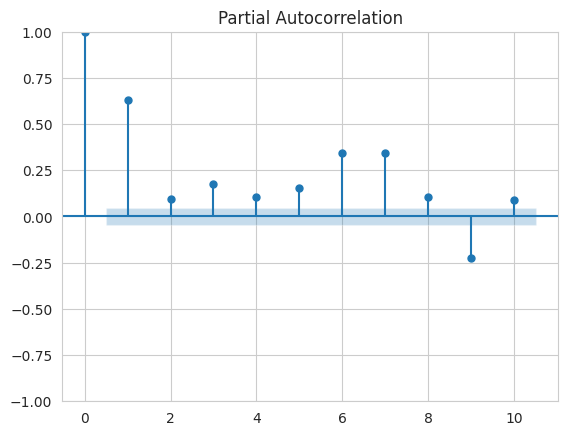

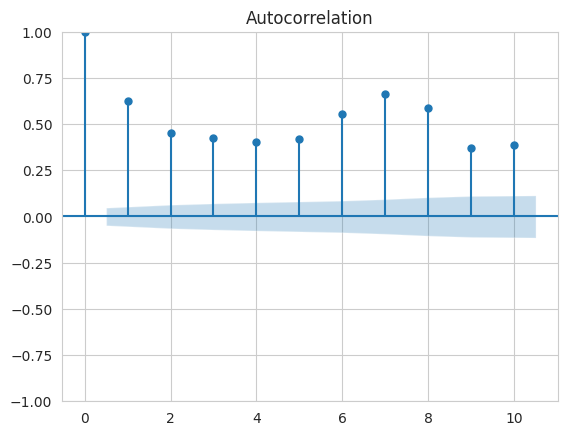

In [ ]:
plt.figure(figsize=(5,8))
pacf = plot_pacf(combined['sales'],lags =10)
acf = plot_acf(combined['sales'],lags =10)

##### Stationarity Test

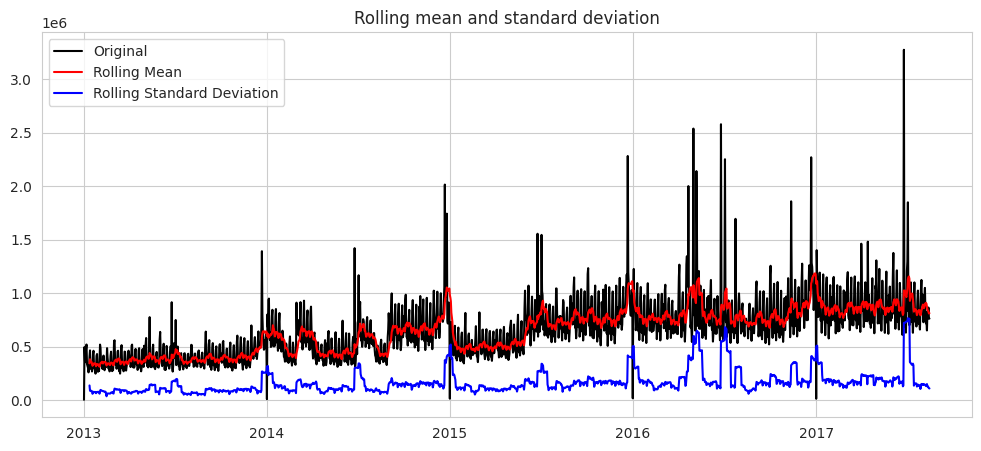

In [ ]:
plt.figure(figsize=(12,5))
rmean=combined['sales'].rolling(window=12).mean()
rstd=combined['sales'].rolling(window=12).std()
# print(rmean,rstd)
orig=plt.plot(combined['sales'], color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show();

###### Comment:
From the graph above, the rolling mean and rolling standard deviation is constant, thus the dataset can be said to be stationary

#### Ar Model

In [ ]:
model1 =AutoReg(train_data, lags=5).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1346
Model:                     AutoReg(5)   Log Likelihood              -18194.672
Method:               Conditional MLE   S.D. of innovations         188914.485
Date:                Sat, 29 Apr 2023   AIC                          36403.345
Time:                        16:23:38   BIC                          36439.753
Sample:                             5   HQIC                         36416.984
                                 1346                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.256e+05   1.64e+04      7.679      0.000    9.36e+04    1.58e+05
sales.L1       0.5466      0.027     20.223      0.000       0.494       0.600
sales.L2      -0.0540      0.031     -1.748      0.080      -0.114       0.007
sales.L3       0.1489      0.031      4.858      0.000       0.089       0.209
sales.L4       0.0030      0.031      0.096      0.924      -0.058       0.063
sales.L5       0.1465      0.027      5.417      0.000       0.093       0.199
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1123           -0.0000j            1.1123           -0.0000
AR.2            0.5849           -1.3983j            1.5157           -0.1869
AR.3            0.5849           +1.3983j            1.5157            0.1869
AR.4           -1.1511           -1.1605j            1.6346           -0.3744
AR.5           -1.1511           +1.1605j            1.6346            0.3744
-----------------------------------------------------------------------------
"""

##### Predictions

In [ ]:
Ar_pred = model1.predict(start =len(train_data),
                       end = len(train_data) +len(test_data)-1,
                       dynamic =False)

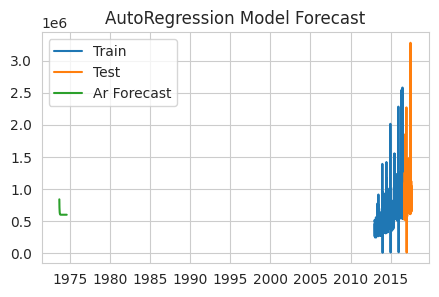

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(train_data['sales'], label ='Train')
plt.plot(test_data['sales'], label ='Test')
plt.plot(Ar_pred, label ='Ar Forecast')
plt.legend(loc='best')
plt.title('AutoRegression Model Forecast')
plt.show;

##### Evaluation

In [ ]:
mse = mean_squared_error(test_data,Ar_pred)
msle = mean_squared_log_error(test_data, Ar_pred)
rmse =np.sqrt(mse).round(2)
rmsle =np.sqrt(msle).round(2)

In [ ]:
results =pd.DataFrame([['AR',mse, msle,rmse,rmsle]], columns =['Model','mse','msle','rmse','rmsle'])

results

,Model,mse,msle,rmse,rmsle
0,AR,"133,593,712,396.329",0.211,"365,504.740",0.460


#### ARIMA

In [ ]:
stepwise_fit = auto_arima(train_data['sales'], trace =True,suppress_warning =True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36357.548, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36862.492, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36781.721, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36524.179, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36860.497, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36369.181, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36388.175, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=36366.788, Time=1.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=36162.299, Time=3.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36363.648, Time=1.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=36150.077, Time=6.33 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=36125.675, Time=3.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=36242.328, Time=3.84 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=36166.751, Time=3.70 sec
 ARIMA(4,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1346
Model:               SARIMAX(4, 1, 3)   Log Likelihood              -18053.591
Date:                Sat, 29 Apr 2023   AIC                          36123.183
Time:                        16:25:35   BIC                          36164.816
Sample:                             0   HQIC                         36138.778
                               - 1346                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3161      0.023     56.049      0.000       1.270       1.362
ar.L2         -1.2230      0.037    -32.883      0.000      -1.296      -1.150
ar.L3          0.2416      0.040      5.976      0.000       0.162       0.321
ar.L4         -0.1302      0.031     -4.134      0.000      -0.192      -0.068
ma.L1         -2.0166      0.019   -107.547      0.000      -2.053      -1.980
ma.L2          1.9491      0.026     75.041      0.000       1.898       2.000
ma.L3         -0.8017      0.018    -44.071      0.000      -0.837      -0.766
sigma2      2.755e+10   6.08e-13   4.53e+22      0.000    2.75e+10    2.75e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             50387.13
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             3.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+39. Standard errors may be unstable.
"""

In [ ]:
model2 = ARIMA(train_data, order=(4,1,3))
model_fit = model2.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1346
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -18053.591
Date:                Sat, 29 Apr 2023   AIC                          36123.183
Time:                        16:25:51   BIC                          36164.816
Sample:                             0   HQIC                         36138.778
                               - 1346                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3161      0.023     56.049      0.000       1.270       1.362
ar.L2         -1.2230      0.037    -32.883      0.000      -1.296      -1.150
ar.L3          0.2416      0.040      5.976      0.000       0.162       0.321
ar.L4         -0.1302      0.031     -4.134      0.000      -0.192      -0.068
ma.L1         -2.0166      0.019   -107.547      0.000      -2.053      -1.980
ma.L2          1.9491      0.026     75.041      0.000       1.898       2.000
ma.L3         -0.8017      0.018    -44.071      0.000      -0.837      -0.766
sigma2      2.755e+10   6.08e-13   4.53e+22      0.000    2.75e+10    2.75e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             50387.13
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             3.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+39. Standard errors may be unstable.
"""

##### Prediction

In [ ]:
Arima_pred = model_fit.predict(start =len(train_data),
                       end = len(train_data) +len(test_data)-1,
                       typ ='levels')

print(Arima_pred)

1346   830,060.096
1347   701,254.047
1348   666,935.327
1349   720,840.775
1350   827,025.322
           ...    
1678   821,047.664
1679   833,913.730
1680   817,441.353
1681   784,306.799
1682   759,707.190
Name: predicted_mean, Length: 337, dtype: float64


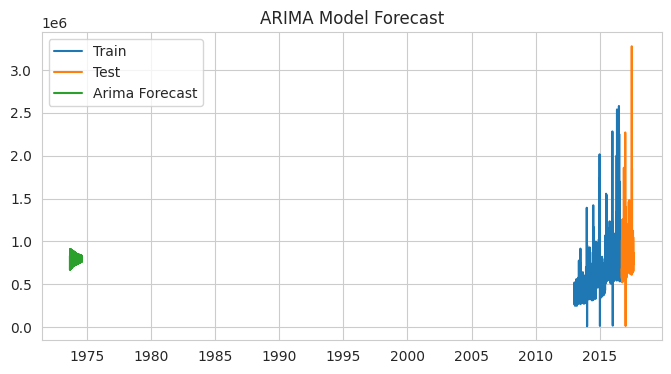

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_data['sales'], label ='Train')
plt.plot(test_data['sales'], label ='Test')
plt.plot(Arima_pred, label ='Arima Forecast')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast')
plt.show();

###### Evaluation

In [ ]:
mse = mean_squared_error(test_data,Arima_pred)
msle = mean_squared_log_error(test_data, Arima_pred)
rmse =np.sqrt(mse).round(2)
rmsle =np.sqrt(msle).round(2)

results1 =pd.DataFrame([['ARIMA',mse, msle,rmse,rmsle]], columns =['Model','mse','msle','rmse','rmsle'])

results = results.append(results1,ignore_index =True)

results

,Model,mse,msle,rmse,rmsle
0,AR,"133,593,712,396.329",0.211,"365,504.740",0.460
1,ARIMA,"60,445,940,232.248",0.100,"245,857.560",0.320


##### Comment:

The ARIMA model performs better than the AR model

#### Multivariate Forecasting with Sales as dependent variable

#### Linear Model

In [ ]:
# Linear Regression Model
lr = LinearRegression()
model = lr.fit(X_train, y_train)

# Make prediction on X_test
lr_predictions = lr.predict(X_test)

In [ ]:
# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)

# Print the evaluation results for Linear Regression model
print("\nEvaluation Results for Linear Regression:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("RMSLE:", lr_rmsle)


Evaluation Results for Linear Regression:
MSE: 0.69
RMSE: 0.83
RMSLE: 0.27


In [ ]:
from sklearn.metrics import mean_squared_error

# predict on test set
y_pred = model.predict(X_test)

# calculate MSE
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.69


#### Decision Tree Regression Model

In [74]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Make prediction on X_test
dt_predictions = dt.predict(X_test)

# Evaluation Metrics for Decision Tree Regression
dt_mse = mean_squared_error(y_test, dt_predictions).round(2)
dt_rmse = np.sqrt(dt_mse).round(2)

# Evaluation Metrics for Decision Tree Regression
dt_predictions_abs = abs(dt_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and dt_predictions_abs array
dt_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, dt_predictions_abs)).round(2)

# Print the evaluation results for Decision Tree Regression model
print("\nEvaluation Results for Decision Tree Regression:")
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)

print("RMLSE:", dt_rmsle)


Evaluation Results for Decision Tree Regression:
MSE: 0.07
RMSE: 0.26
RMLSE: 0.06


#### XGBoost Model

In [75]:
# create an instance of the XGBRegressor class
xgb_model = xgb.XGBRegressor()

# fit the model on the training data
xgb_model.fit(X_train, y_train)

# make predictions on the test data
xgb_predictions = xgb_model.predict(X_test)

In [76]:
# Evaluation Metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_predictions).round(2)
xgb_rmse = np.sqrt(xgb_mse).round(2)

#y_test_abs = abs(y_test)
xgb_predictions_abs = abs(xgb_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and xgb_predictions_abs array
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, xgb_predictions_abs)).round(2)

# Print the evaluation results for XGBoost model
print("\nEvaluation Results for XGBoost:")
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("RMSLE:", xgb_rmsle)


Evaluation Results for XGBoost:
MSE: 0.12
RMSE: 0.35
RMSLE: 0.12


#### Random Forest Regression Model

In [77]:
# Random Forest Regression Model
rf = RandomForestRegressor(n_estimators=20, random_state=42)
rf.fit(X_train, y_train)

# Make prediction on X_test
rf_predictions = rf.predict(X_test)

In [78]:
# Evaluation Metrics for Random Forest Regression
rf_mse = mean_squared_error(y_test, rf_predictions).round(2)
rf_rmse = np.sqrt(rf_mse).round(2)

# apply the absolute value function to y_test to remove negative signs
rf_predictions_abs = abs(rf_predictions)

# calculate the mean squared logarithmic error using the new y_test_abs and rf_predictions_abs array
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, rf_predictions_abs)).round(2)

# Print the evaluation results for Random Forest Regrression model
print("\nEvaluation Results for Random Forest:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("RMSLE:", rf_rmsle)
                                          


Evaluation Results for Random Forest:
MSE: 0.04
RMSE: 0.2
RMSLE: 0.05


### Evaluation

In [79]:
# Define a table to compare evaluation results
evaluation_metrics = ['MSE', 'RMSE', 'RMSLE']
models = ['Linear Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = [[lr_mse, lr_rmse, lr_rmsle],
           [dt_mse, dt_rmse, dt_rmsle],
           [xgb_mse, xgb_rmse, xgb_rmsle],
           [rf_mse, rf_rmse, rf_rmsle]]
results_table = pd.DataFrame(data=results, columns=evaluation_metrics, index=models)

# Print the comparison table
print("Comparison Table of Evaluation Results:\n", results_table)


Comparison Table of Evaluation Results:
                     MSE  RMSE  RMSLE
Linear Regression 0.690 0.830  0.270
Decision Tree     0.070 0.260  0.060
XGBoost           0.120 0.350  0.120
Random Forest     0.040 0.200  0.050


#### Comments

* From the evaluation metric summary, the decision tree model performs better than the other models 